In [ ]:
%pip install pandas_ta
import pandas as pd
import numpy as np
import datetime as dt
from datetime import timedelta
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import pandas_ta as ta
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from google.colab import files
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
import torch.optim as optim
from sklearn.metrics import mean_squared_error, r2_score



In [ ]:
def convertDatetime(stringDate):
  splitDate = stringDate.split("-")
  year = int(splitDate[0])
  month = int(splitDate[1])
  day = int(splitDate[2])
  return dt.datetime(year=year, month=month, day=day)

In [ ]:
def DFDateAvg(thisdict):
  data = {'Year', 'Month', 'Day', 'AVG', 'QUANTITY'}
  listDate = []
  listYear = []
  listMonth = []
  listAvg = []
  listQuantity = []

  quantity = thisdict.pop("Qauntity")
  for x in thisdict.keys():
    listDate.append(x)
    listYear.append(x.year)
    listMonth.append(x.month)
    listAvg.append(thisdict[x])
    listQuantity.append(quantity.get(x, 0))

  data = {'DATE': listDate,
          #'YEAR': listYear,
          #'MONTH': listMonth,
        'AVG': listAvg,
        'QUANTITY': listQuantity}

  dfclean = pd.DataFrame(data)
  return dfclean

In [ ]:
def getMeanOfPlatinum(df):
  #bad names i know. tempdict stores the timezones and its total values added up
  #tempdict2 stores how many times the same date was called. using both to calculate the mean
  tempdict = {}
  tempdict2 = {}

  tempdict3 = {}
  for x in range(0, len(df)):
    if dt.datetime(year = df.index[x].year, month = df.index[x].month, day = df.index[x].day) in tempdict:
      tempdict[dt.datetime(year = df.index[x].year, month = df.index[x].month, day = df.index[x].day)] += df['PLATINUM'].iloc[x]
      tempdict3[dt.datetime(year = df.index[x].year, month = df.index[x].month, day = df.index[x].day)] += df['QUANTITY'].iloc[x]
      tempdict2[dt.datetime(year = df.index[x].year, month = df.index[x].month, day = df.index[x].day)] += 1
    else:
      tempdict[dt.datetime(year = df.index[x].year, month = df.index[x].month, day = df.index[x].day)] = df['PLATINUM'].iloc[x]
      tempdict3[dt.datetime(year = df.index[x].year, month = df.index[x].month, day = df.index[x].day)] = df['QUANTITY'].iloc[x]
      tempdict2[dt.datetime(year = df.index[x].year, month = df.index[x].month, day = df.index[x].day)] = 1
  for x in tempdict:
    tempdict[x] = tempdict[x]/tempdict2[x]
  tempdict["Qauntity"] = tempdict3


  return tempdict

In [ ]:
def create_sequences(data, target_col, sequence_length):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i])
        y.append(data[i, target_col])
    return np.array(X), np.array(y)

In [ ]:
!wget https://raw.githubusercontent.com/KTTRed/CSVURLPublic/refs/heads/main/WM_DataCLEANED.zip

--2024-12-13 01:03:34--  https://raw.githubusercontent.com/KTTRed/CSVURLPublic/refs/heads/main/WM_DataCLEANED.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11383553 (11M) [application/zip]
Saving to: ‘WM_DataCLEANED.zip.2’

WM_DataCLEANED.zip. 100%[===================>]  10.86M  --.-KB/s    in 0.1s    

2024-12-13 01:03:35 (89.6 MB/s) - ‘WM_DataCLEANED.zip.2’ saved [11383553/11383553]



In [ ]:
!unzip /content/WM_DataCLEANED.zip

Archive:  /content/WM_DataCLEANED.zip
  inflating: WM_DataCLEANED.csv      


In [ ]:
df = pd.read_csv('/content/WM_DataCLEANED.csv')

In [ ]:
df['DATE']

,DATE
0,2018-04-05
1,2019-11-01
2,2020-02-16
3,2021-01-21
4,2021-03-29
...,...
604529,2024-12-05
604530,2024-12-07
604531,2024-12-08
604532,2024-12-08


In [ ]:
df['DATE'] = df['DATE'].apply(convertDatetime)

In [ ]:
#gets only the nekros prime set item as a dataframe, but you could technically get any item
item = 'nekros_prime_set'
dfitem = df[df['ITEM_NAME']== item]

In [ ]:
dfBUY = dfitem[dfitem['ORDERTYPE'] == 'OrderType.buy']
dfSELL = dfitem[dfitem['ORDERTYPE'] == 'OrderType.sell']

In [ ]:
dfBUY

,Unnamed: 0,ID,ITEM_NAME,PLATINUM,QUANTITY,ORDERTYPE,DATE
574420,574420,5eeb8b02aad7770933f345f0,nekros_prime_set,91,1,OrderType.buy,2020-06-18
574441,574441,61e19d46f6495f12e4551ffd,nekros_prime_set,80,1,OrderType.buy,2022-01-14
574442,574442,61edf7890ac48001f551e921,nekros_prime_set,55,5,OrderType.buy,2022-01-24
574449,574449,62a5f04c5658b307062aead5,nekros_prime_set,70,1,OrderType.buy,2022-06-12
574450,574450,62f156b258014205ef9fec69,nekros_prime_set,70,100,OrderType.buy,2022-08-08
...,...,...,...,...,...,...,...
575299,575299,67550fb3d3363000070fec51,nekros_prime_set,91,2,OrderType.buy,2024-12-07
575300,575300,6755201622a831000865d266,nekros_prime_set,20,1,OrderType.buy,2024-12-07
575303,575303,6755365f455969000752ec14,nekros_prime_set,30,1,OrderType.buy,2024-12-07
575321,575321,6755cd58d07b73000aff3aee,nekros_prime_set,96,1,OrderType.buy,2024-12-07


In [ ]:
dfSELL

,Unnamed: 0,ID,ITEM_NAME,PLATINUM,QUANTITY,ORDERTYPE,DATE
574403,574403,58ef909cd3ffb61d1a0e9d01,nekros_prime_set,115,1,OrderType.sell,2017-04-13
574404,574404,59c434d30f3139783318e5f0,nekros_prime_set,130,2,OrderType.sell,2017-09-21
574405,574405,5b451389e147a802bcca7e29,nekros_prime_set,149,2,OrderType.sell,2018-07-10
574406,574406,5b4a1825047f2500eaf4f790,nekros_prime_set,120,1,OrderType.sell,2018-07-14
574407,574407,5ba0f8cff524070146ef3e48,nekros_prime_set,105,3,OrderType.sell,2018-09-18
...,...,...,...,...,...,...,...
575323,575323,6755e767d07b73000aff3cf7,nekros_prime_set,100,1,OrderType.sell,2024-12-07
575324,575324,6755e98c3d967b000839020e,nekros_prime_set,104,1,OrderType.sell,2024-12-07
575325,575325,6755e9a33d967b000976aca5,nekros_prime_set,110,3,OrderType.sell,2024-12-07
575326,575326,6755ff4f3d967b00083903d1,nekros_prime_set,100,1,OrderType.sell,2024-12-07


In [ ]:
dfBUY['DATE']

,DATE
574420,2020-06-18
574441,2022-01-14
574442,2022-01-24
574449,2022-06-12
574450,2022-08-08
...,...
575299,2024-12-07
575300,2024-12-07
575303,2024-12-07
575321,2024-12-07


In [ ]:
#df.index = df['DATE']

In [ ]:
dfBUY.index = dfBUY.pop('DATE')

In [ ]:
dfSELL.index = dfSELL.pop('DATE')

In [ ]:
dfBUY.drop('Unnamed: 0', axis = 1)

,ID,ITEM_NAME,PLATINUM,QUANTITY,ORDERTYPE
DATE,,,,,
2020-06-18,5eeb8b02aad7770933f345f0,nekros_prime_set,91,1,OrderType.buy
2022-01-14,61e19d46f6495f12e4551ffd,nekros_prime_set,80,1,OrderType.buy
2022-01-24,61edf7890ac48001f551e921,nekros_prime_set,55,5,OrderType.buy
2022-06-12,62a5f04c5658b307062aead5,nekros_prime_set,70,1,OrderType.buy
2022-08-08,62f156b258014205ef9fec69,nekros_prime_set,70,100,OrderType.buy
...,...,...,...,...,...
2024-12-07,67550fb3d3363000070fec51,nekros_prime_set,91,2,OrderType.buy
2024-12-07,6755201622a831000865d266,nekros_prime_set,20,1,OrderType.buy
2024-12-07,6755365f455969000752ec14,nekros_prime_set,30,1,OrderType.buy


In [ ]:
dfSELL.drop('Unnamed: 0', axis = 1)

,ID,ITEM_NAME,PLATINUM,QUANTITY,ORDERTYPE
DATE,,,,,
2017-04-13,58ef909cd3ffb61d1a0e9d01,nekros_prime_set,115,1,OrderType.sell
2017-09-21,59c434d30f3139783318e5f0,nekros_prime_set,130,2,OrderType.sell
2018-07-10,5b451389e147a802bcca7e29,nekros_prime_set,149,2,OrderType.sell
2018-07-14,5b4a1825047f2500eaf4f790,nekros_prime_set,120,1,OrderType.sell
2018-09-18,5ba0f8cff524070146ef3e48,nekros_prime_set,105,3,OrderType.sell
...,...,...,...,...,...
2024-12-07,6755e767d07b73000aff3cf7,nekros_prime_set,100,1,OrderType.sell
2024-12-07,6755e98c3d967b000839020e,nekros_prime_set,104,1,OrderType.sell
2024-12-07,6755e9a33d967b000976aca5,nekros_prime_set,110,3,OrderType.sell


In [ ]:
dfSELL.describe()

,Unnamed: 0,PLATINUM,QUANTITY
count,758.000000,758.000000,758.000000
mean,574848.674142,130.114776,6.819261
std,266.232416,180.269866,24.789636
min,574403.000000,80.000000,1.000000
25%,574618.250000,105.000000,1.000000
50%,574835.500000,110.000000,1.000000
75%,575071.750000,128.000000,3.000000
max,575327.000000,5000.000000,500.000000


In [ ]:
dfSELL = dfSELL.drop(['ID', 'ORDERTYPE', 'ITEM_NAME'], axis = 1)

In [ ]:
dfSELL['TIMESTAMP'] = (dfSELL.index - dfSELL.index.min()).days

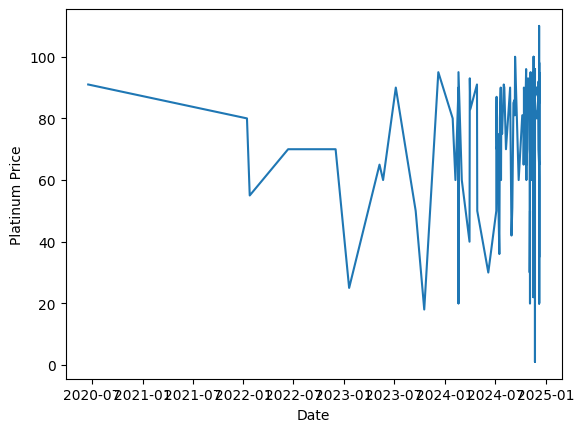

In [ ]:
plt.plot(dfBUY.index, dfBUY['PLATINUM'])
plt.xlabel("Date")
plt.ylabel('Platinum Price')
plt.show()

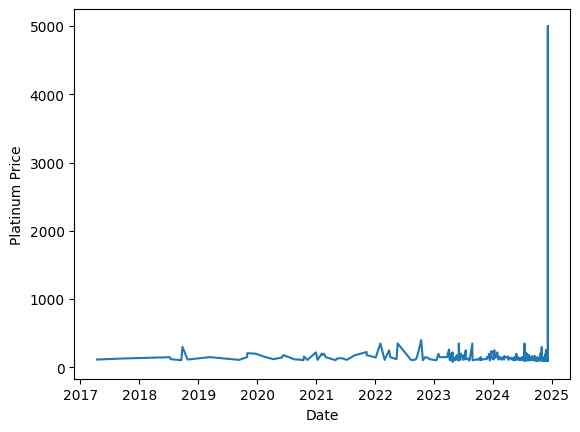

In [ ]:
plt.plot(dfSELL.index, dfSELL['PLATINUM'])
plt.xlabel("Date")
plt.ylabel('Platinum Price')
plt.show()

In [ ]:
thresholdSell = dfSELL['PLATINUM'].quantile(0.95)
thresholdBuy = dfBUY['PLATINUM'].quantile(0.02)

In [ ]:
thresholdBuy

20.0

In [ ]:
thresholdSell

180.0

In [ ]:
dfSELL = dfSELL[dfSELL['PLATINUM'] < thresholdSell]
dfBUY = dfBUY[dfBUY['PLATINUM'] > thresholdBuy]

In [ ]:
dfBUY = dfBUY[dfBUY.index.year == 2024]
dfSELL = dfSELL[dfSELL.index.year == 2024]

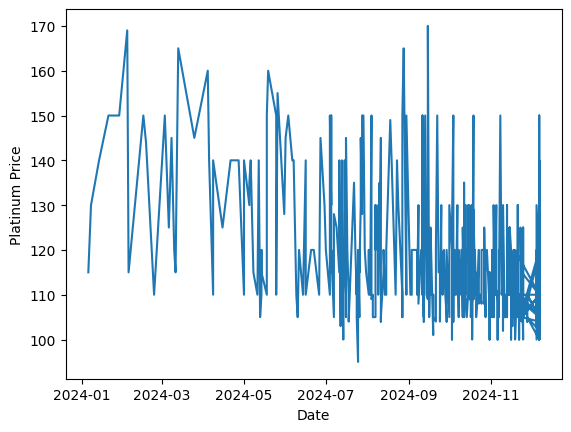

In [ ]:
plt.plot(dfSELL.index, dfSELL['PLATINUM'])
plt.xlabel("Date")
plt.ylabel('Platinum Price')
plt.show()

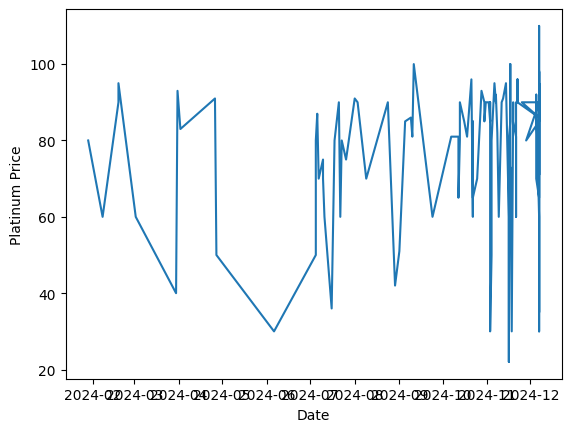

In [ ]:
plt.plot(dfBUY.index, dfBUY['PLATINUM'])
plt.xlabel("Date")
plt.ylabel('Platinum Price')
plt.show()

In [ ]:
uniqueDates = dfBUY.index.unique()

In [ ]:
uniqueDates

DatetimeIndex(['2024-01-29', '2024-02-08', '2024-02-19', '2024-03-02',
               '2024-03-30', '2024-03-31', '2024-04-02', '2024-04-26',
               '2024-04-27', '2024-06-06', '2024-07-05', '2024-07-06',
               '2024-07-07', '2024-07-10', '2024-07-11', '2024-07-16',
               '2024-07-18', '2024-07-21', '2024-07-22', '2024-07-23',
               '2024-07-26', '2024-08-01', '2024-08-03', '2024-08-09',
               '2024-08-24', '2024-08-29', '2024-09-01', '2024-09-05',
               '2024-09-09', '2024-09-10', '2024-09-11', '2024-09-24',
               '2024-10-07', '2024-10-12', '2024-10-13', '2024-10-16',
               '2024-10-18', '2024-10-21', '2024-10-22', '2024-10-25',
               '2024-10-28', '2024-10-30', '2024-10-31', '2024-11-02',
               '2024-11-03', '2024-11-04', '2024-11-06', '2024-11-07',
               '2024-11-08', '2024-11-09', '2024-11-11', '2024-11-12',
               '2024-11-14', '2024-11-16', '2024-11-17', '2024-11-18',
      

In [ ]:
meanDictBuy = getMeanOfPlatinum(dfBUY)

In [ ]:
meanDictSell = getMeanOfPlatinum(dfSELL)

In [ ]:
meanDictBuy

{datetime.datetime(2024, 1, 29, 0, 0): 80.0,
 datetime.datetime(2024, 2, 8, 0, 0): 60.0,
 datetime.datetime(2024, 2, 19, 0, 0): 92.5,
 datetime.datetime(2024, 3, 2, 0, 0): 60.0,
 datetime.datetime(2024, 3, 30, 0, 0): 40.0,
 datetime.datetime(2024, 3, 31, 0, 0): 93.0,
 datetime.datetime(2024, 4, 2, 0, 0): 83.0,
 datetime.datetime(2024, 4, 26, 0, 0): 91.0,
 datetime.datetime(2024, 4, 27, 0, 0): 50.0,
 datetime.datetime(2024, 6, 6, 0, 0): 30.0,
 datetime.datetime(2024, 7, 5, 0, 0): 65.0,
 datetime.datetime(2024, 7, 6, 0, 0): 87.0,
 datetime.datetime(2024, 7, 7, 0, 0): 70.0,
 datetime.datetime(2024, 7, 10, 0, 0): 72.5,
 datetime.datetime(2024, 7, 11, 0, 0): 60.0,
 datetime.datetime(2024, 7, 16, 0, 0): 36.0,
 datetime.datetime(2024, 7, 18, 0, 0): 80.0,
 datetime.datetime(2024, 7, 21, 0, 0): 90.0,
 datetime.datetime(2024, 7, 22, 0, 0): 60.0,
 datetime.datetime(2024, 7, 23, 0, 0): 80.0,
 datetime.datetime(2024, 7, 26, 0, 0): 75.0,
 datetime.datetime(2024, 8, 1, 0, 0): 91.0,
 datetime.datetime

In [ ]:
meanDictSell

{datetime.datetime(2024, 1, 6, 0, 0): 115.0,
 datetime.datetime(2024, 1, 8, 0, 0): 130.0,
 datetime.datetime(2024, 1, 14, 0, 0): 140.0,
 datetime.datetime(2024, 1, 21, 0, 0): 150.0,
 datetime.datetime(2024, 1, 22, 0, 0): 150.0,
 datetime.datetime(2024, 1, 29, 0, 0): 150.0,
 datetime.datetime(2024, 2, 4, 0, 0): 169.0,
 datetime.datetime(2024, 2, 5, 0, 0): 115.0,
 datetime.datetime(2024, 2, 16, 0, 0): 150.0,
 datetime.datetime(2024, 2, 18, 0, 0): 144.0,
 datetime.datetime(2024, 2, 24, 0, 0): 110.0,
 datetime.datetime(2024, 3, 3, 0, 0): 150.0,
 datetime.datetime(2024, 3, 6, 0, 0): 125.0,
 datetime.datetime(2024, 3, 8, 0, 0): 145.0,
 datetime.datetime(2024, 3, 10, 0, 0): 120.0,
 datetime.datetime(2024, 3, 11, 0, 0): 115.0,
 datetime.datetime(2024, 3, 13, 0, 0): 165.0,
 datetime.datetime(2024, 3, 16, 0, 0): 160.0,
 datetime.datetime(2024, 3, 25, 0, 0): 145.0,
 datetime.datetime(2024, 4, 4, 0, 0): 160.0,
 datetime.datetime(2024, 4, 5, 0, 0): 140.0,
 datetime.datetime(2024, 4, 7, 0, 0): 120.0

In [ ]:
dfBUYclean = DFDateAvg(meanDictBuy)

In [ ]:
dfSELLclean = DFDateAvg(meanDictSell)

In [ ]:
dfBUYclean['RETURN'] = dfBUYclean['AVG'].pct_change()
dfSELLclean['RETURN'] = dfSELLclean['AVG'].pct_change()

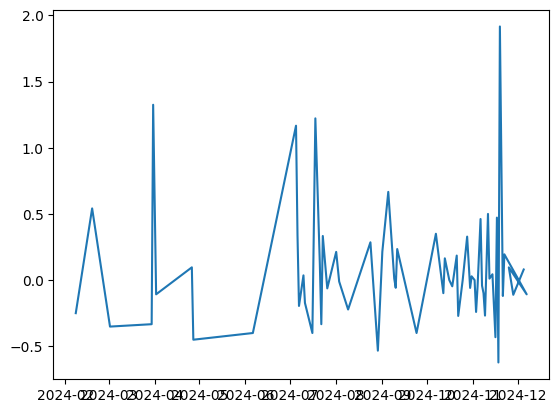

In [ ]:
plt.plot(dfBUYclean['DATE'], dfBUYclean['RETURN'])

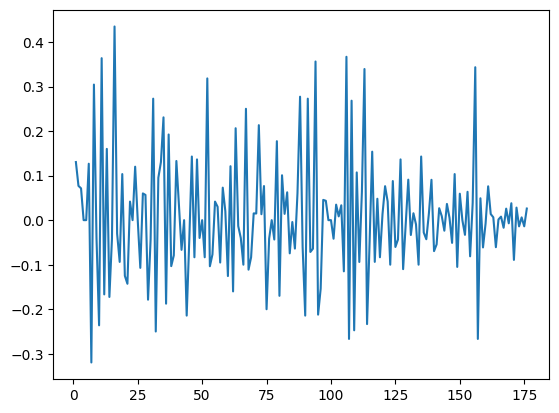

In [ ]:
plt.plot(dfSELLclean.index, dfSELLclean['RETURN'])

In [ ]:
def addIndicators(df):
  df['RSI'] = ta.rsi(df.AVG, length = 5)

In [ ]:
addIndicators(dfBUYclean)

In [ ]:
addIndicators(dfSELLclean)

In [ ]:
dfBUYclean

,DATE,AVG,QUANTITY,RETURN,RSI
0,2024-01-29,80.000000,10,NaN,NaN
1,2024-02-08,60.000000,5,-0.250000,NaN
2,2024-02-19,92.500000,7,0.541667,NaN
3,2024-03-02,60.000000,1,-0.351351,NaN
4,2024-03-30,40.000000,3,-0.333333,NaN
...,...,...,...,...,...
58,2024-11-22,92.000000,3,0.194805,57.312239
59,2024-12-07,82.101695,10174,-0.107590,52.137369
60,2024-11-25,90.000000,2,0.096201,56.091773
61,2024-11-28,80.000000,5,-0.111111,49.605563


In [ ]:
dfSELLclean

,DATE,AVG,QUANTITY,RETURN,RSI
0,2024-01-06,115.000000,5,NaN,NaN
1,2024-01-08,130.000000,6,0.130435,NaN
2,2024-01-14,140.000000,8,0.076923,NaN
3,2024-01-21,150.000000,1,0.071429,NaN
4,2024-01-22,150.000000,1,0.000000,NaN
...,...,...,...,...,...
172,2024-11-23,108.857143,12,0.028167,43.355419
173,2024-11-24,107.333333,25,-0.013998,39.967698
174,2024-11-25,108.000000,9,0.006211,42.427865
175,2024-11-28,106.500000,6,-0.013889,38.043084


In [ ]:
#dfSELLclean = dfSELLclean.drop('DATE', axis=1)

In [ ]:
dfSELLclean.set_index('DATE', inplace = True)

In [ ]:
dfSELLcleanResample = dfSELLclean.resample('D').mean()
dfSELLcleanResample['AVG'] = dfSELLcleanResample['AVG'].interpolate(method='linear')

In [ ]:
dfSELLcleanResample.drop(['RSI', 'RETURN'], axis = 1)
addIndicators(dfSELLcleanResample)
dfSELLcleanResample['RETURN'] = dfSELLcleanResample['AVG'].pct_change()

In [ ]:
dfSELLcleanResample['RETURNLAG1'] = dfSELLcleanResample['RETURN'].shift(1)
dfSELLcleanResample['RETURNLAG2'] = dfSELLcleanResample['RETURN'].shift(2)

In [ ]:
dfSELLcleanResample['QUANTITY'] = dfSELLcleanResample['QUANTITY'].fillna(1)

In [ ]:
dfSELLcleanResample

,AVG,QUANTITY,RETURN,RSI,RETURNLAG1,RETURNLAG2
DATE,,,,,,
2024-01-06,115.000000,5.0,NaN,NaN,NaN,NaN
2024-01-07,122.500000,1.0,0.065217,NaN,NaN,NaN
2024-01-08,130.000000,6.0,0.061224,NaN,0.065217,NaN
2024-01-09,131.666667,1.0,0.012821,NaN,0.061224,0.065217
2024-01-10,133.333333,1.0,0.012658,NaN,0.012821,0.061224
...,...,...,...,...,...,...
2024-12-03,108.480519,1.0,0.003665,55.464932,0.003678,0.003692
2024-12-04,108.876623,1.0,0.003651,59.908967,0.003665,0.003678
2024-12-05,109.272727,16.0,0.003638,64.355103,0.003651,0.003665


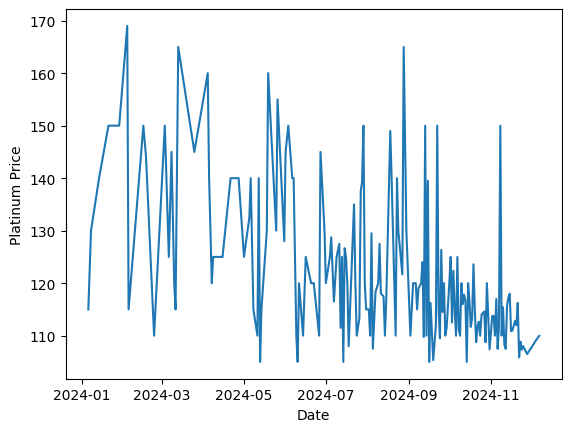

In [ ]:
plt.plot(dfSELLcleanResample.index, dfSELLcleanResample['AVG'])
plt.xlabel("Date")
plt.ylabel('Platinum Price')
plt.show()

In [ ]:
dfSELLcleanResample.describe()

,AVG,QUANTITY,RETURN,RSI,RETURNLAG1,RETURNLAG2
count,337.000000,337.000000,336.000000,332.000000,335.000000,334.000000
mean,127.579976,11.919881,0.003266,52.787568,0.003266,0.003267
std,15.636132,42.724924,0.083642,21.034768,0.083767,0.083892
min,105.000000,1.000000,-0.319527,8.461863,-0.319527,-0.319527
25%,115.000000,1.000000,-0.033602,39.521212,-0.033871,-0.034140
50%,125.000000,1.000000,0.000000,49.081311,0.000000,0.000000
75%,140.000000,6.000000,0.026368,62.576029,0.026519,0.026669
max,169.000000,513.000000,0.366743,100.000000,0.366743,0.366743


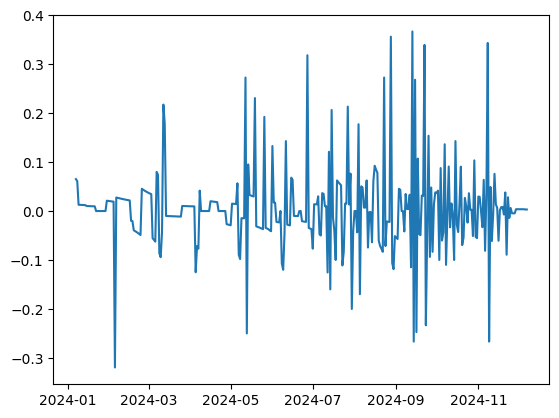

In [ ]:
plt.plot(dfSELLcleanResample.index, dfSELLcleanResample['RETURN'])

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, h0=None, c0=None):
        if h0 is None or c0 is None:
            h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
            c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)

        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out, hn, cn

In [ ]:
dfSELLcleanResample['TIMESTAMP'] = (dfSELLcleanResample.index - dfSELLcleanResample.index.min()).days

In [ ]:
dfSELLcleanResample['YEAR'] = dfSELLcleanResample.index.year
dfSELLcleanResample['MONTH'] = dfSELLcleanResample.index.month
dfSELLcleanResample['DAY'] = dfSELLcleanResample.index.day
#fSELLcleanResample['DOY'] = dfSELLcleanResample.index.dayofyear #this was a bad idea it just made the model worst
dfSELLcleanResample['DOW'] = dfSELLcleanResample.index.dayofweek

In [ ]:
dfSELLcleanResample['logAVG'] = np.log(dfSELLcleanResample['AVG'])

In [ ]:
#debugging just to look at the CSV with all its features
#dfSELLcleanResample.to_csv('DFSELLcleanResample.csv')

In [ ]:
dfSELLcleanResample.dropna(inplace=True)

In [ ]:
scaleThis = dfSELLcleanResample[['RETURN', 'DAY', 'MONTH', 'logAVG', 'RETURNLAG1', 'RETURNLAG2', 'DOW']]

In [ ]:
scaledDataX = StandardScaler().fit_transform(scaleThis)

In [ ]:
#hyperparamaters
sequence_len = 10
input_len = len(scaleThis.columns)
hidden_size = 128
num_layers = 2
num_classes = len(dfSELLclean.columns)
num_epochs = 50
learning_rate = 0.01

In [ ]:
X, Y = create_sequences(scaledDataX, 0, sequence_len)

In [ ]:
XTensor = torch.tensor(X, dtype=torch.float32)
YTensor = torch.tensor(Y, dtype=torch.float32)

In [ ]:
dataset = TensorDataset(XTensor, YTensor)

In [ ]:
train_size = int(len(dataset) * 0.8)  # 80% training, 20% testing
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
model = LSTMModel(input_dim=input_len, hidden_dim=hidden_size, layer_dim=num_layers, output_dim=1)
criterion = nn.MSELoss()
optimizer = optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [ ]:
h0, c0 = None, None
YTensor = YTensor.view(-1, 1)
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs, _, _ = model(inputs, h0, c0)

        loss = criterion(outputs, targets.view(-1, 1))
        epoch_loss += loss.item()

        loss.backward()


        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader)}")

Epoch 1/50, Loss: 0.9796332774890794
Epoch 2/50, Loss: 0.9567338951811608
Epoch 3/50, Loss: 0.8380660749971867
Epoch 4/50, Loss: 0.8434343735376993
Epoch 5/50, Loss: 0.7103530260630779
Epoch 6/50, Loss: 0.6768320848544439
Epoch 7/50, Loss: 1.516305343972312
Epoch 8/50, Loss: 0.7809054466003241
Epoch 9/50, Loss: 0.6677288662952682
Epoch 10/50, Loss: 0.6062490787460573
Epoch 11/50, Loss: 0.6263045701715682
Epoch 12/50, Loss: 0.47942547748486203
Epoch 13/50, Loss: 0.4858679407172733
Epoch 14/50, Loss: 0.5717257360617319
Epoch 15/50, Loss: 0.40904836853345233
Epoch 16/50, Loss: 0.3926156933108966
Epoch 17/50, Loss: 0.512079558438725
Epoch 18/50, Loss: 0.5027714492623798
Epoch 19/50, Loss: 0.593376025557518
Epoch 20/50, Loss: 0.4417098077893671
Epoch 21/50, Loss: 0.4033738523721695
Epoch 22/50, Loss: 0.37096863571140504
Epoch 23/50, Loss: 0.27388629141367143
Epoch 24/50, Loss: 0.23859245744016436
Epoch 25/50, Loss: 0.19548562251859242
Epoch 26/50, Loss: 0.17922192729181713
Epoch 27/50, Loss

Baseline MSE (Average Predictor): 0.8024644550605418
Model MSE: 1.1424495
model r2: -0.4938583414955364
Good Predictions: 44
Bad Predictions:  21
Overall Acurracy:  0.676923076923077


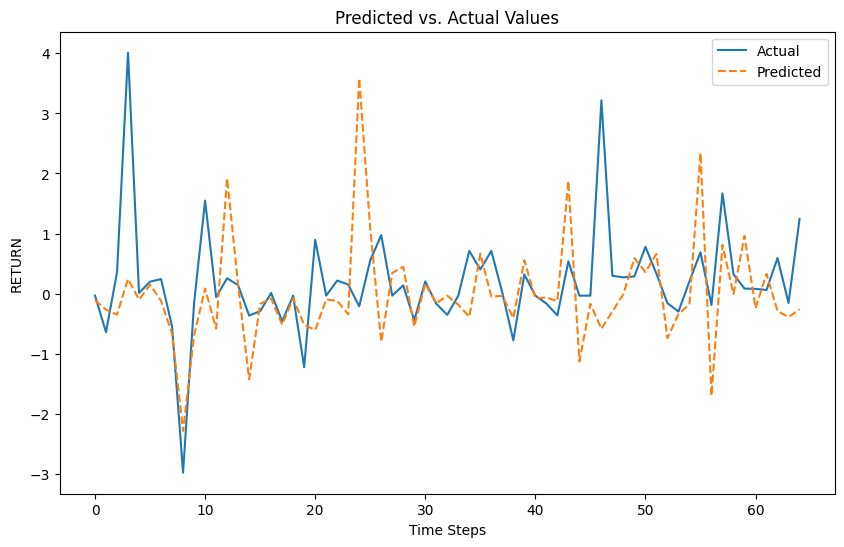

In [ ]:
model.eval()
all_predictions = []
all_targets = []
goodPredictions = 0
badPredictions = 0

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs
        targets = targets

        h0 = torch.zeros(num_layers, inputs.size(0), hidden_size)
        c0 = torch.zeros(num_layers, inputs.size(0), hidden_size)

        outputs, _, _ = model(inputs, h0, c0)

        all_predictions.extend(outputs.cpu().numpy().flatten())
        all_targets.extend(targets.cpu().numpy().flatten())

average_return = np.mean(Y)
baseline_predictions = [average_return] * len(all_targets)
baselineMSE = mean_squared_error(all_targets, baseline_predictions)

mse = mean_squared_error(all_targets, all_predictions)
r2 = r2_score(all_targets, all_predictions)

print("Baseline MSE (Average Predictor):", baselineMSE)

print("Model MSE:", mse)
print("model r2:", r2)

for x in range(0,len(all_targets)):
  if all_targets[x] > 0:
    if all_predictions[x] > 0:
      goodPredictions += 1
    else:
      badPredictions += 1
  elif all_targets[x] < 0:
    if all_predictions[x] < 0:
      goodPredictions += 1
    else:
      badPredictions += 1
  else:
    if all_predictions[x] == 0:
      goodPredictions += 1

print("Good Predictions:", goodPredictions)
print("Bad Predictions: ", badPredictions)
print("Overall Acurracy: ", goodPredictions/(goodPredictions + badPredictions))

plt.figure(figsize=(10, 6))
plt.plot(all_targets, label='Actual')
plt.plot(all_predictions, label='Predicted', linestyle = '--')
plt.legend()
plt.title('Predicted vs. Actual Values')
plt.xlabel('Time Steps')
plt.ylabel('RETURN')
plt.show()


In [ ]:
print(dfSELLcleanResample['AVG'].iloc[1])

136.66666666666666


In [ ]:
print(all_predictions)

[-0.11041491, -0.26760972, -0.3493683, 0.24287207, -0.098843805, 0.14802888, -0.11919709, -0.6657, -2.2859209, -0.69947606, 0.084662534, -0.5815476, 1.9192612, 0.14581852, -1.4290582, -0.17227866, -0.07964934, -0.5146057, -0.08005833, -0.5191424, -0.607233, -0.09745907, -0.12137472, -0.34300488, 3.583428, 1.0865265, -0.80430883, 0.34413722, 0.4462401, -0.54718846, 0.16841441, -0.16192693, -0.03410608, -0.18361382, -0.38798288, 0.66402507, -0.0479949, -0.03822972, -0.40818676, 0.55464154, -0.078568526, -0.06597989, -0.12586813, 1.8757169, -1.1274817, -0.16983767, -0.5860129, -0.29828125, -0.0068942355, 0.5905094, 0.35923597, 0.6616638, -0.7394064, -0.34052458, -0.17955875, 2.3417583, -1.7017602, 0.8091747, -0.007367079, 0.96020967, -0.24317332, 0.32839015, -0.29152432, -0.38935477, -0.26235542]


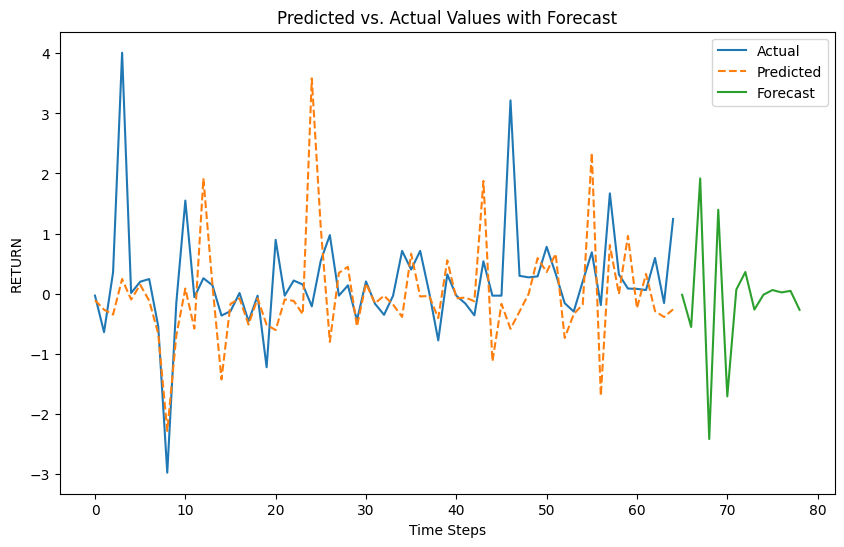

In [ ]:
last_sequence = XTensor[-1].unsqueeze(0)
#predicts next 14 days
forecast_steps = 14
forecast = []

h0 = torch.zeros(num_layers, 1, hidden_size)
c0 = torch.zeros(num_layers, 1, hidden_size)

current_input = last_sequence

for i in range(forecast_steps):
    with torch.no_grad():
        output, h0, c0 = model(current_input, h0, c0)

    forecast.append(output.item())
    output_reshaped = output.repeat(1, 1, input_len)
    current_input = torch.cat([current_input[:, 1:, :], output_reshaped], dim=1)


plt.figure(figsize=(10, 6))
plt.plot(all_targets, label='Actual')
plt.plot(all_predictions, label='Predicted', linestyle='--')
plt.plot(range(len(all_targets), len(all_targets) + forecast_steps),
         forecast, label='Forecast')

plt.legend()
plt.title('Predicted vs. Actual Values with Forecast')
plt.xlabel('Time Steps')
plt.ylabel('RETURN')
plt.show()



In [ ]:
#this code is the market simulation to see how good the model is in theory at flipping warframe
#market sells
initialCash = 2000
inventory = 0
#tweak the thresholds if you wanna try to get better turn out rates
threshholdBuy = -0.5
threshholdSell = 0.2
currentCash = initialCash
prices = dfSELLcleanResample['AVG'].values

In [ ]:
for x in range(len(all_targets)):
    predicted_return = all_predictions[x]
    actual_return = all_targets[x]
    if predicted_return < threshholdBuy and currentCash > 0:
        buy_price = dfSELLcleanResample['AVG'].iloc[x].round()
        currentCash -= buy_price
        inventory += 1
        print("Predicted return:", predicted_return)
        print("Actual return:", actual_return)
        print('Current platinum:', currentCash)
        print("Day", x, ": Bought 1", "items at ", buy_price, "platinum.")
        print('-'*50)
    elif predicted_return > threshholdSell and inventory > 0:
        sell_price = dfSELLcleanResample['AVG'].iloc[x].round()
        currentCash += inventory * sell_price
        print("Predicted return:", predicted_return)
        print("Actual return:", actual_return)
        print('Current platinum:', currentCash)
        print("Day", x, ": Sold", inventory, "items at", buy_price, "platinum.")
        print('-'*50)
        inventory = 0

finalCash = currentCash
inventoryWorth = inventory * dfSELLcleanResample['AVG'].iloc[-1]
networth = finalCash + inventoryWorth
profit = networth - initialCash


print('inventory', inventory)
print('Final Platinum:', finalCash)
print('Net Worth:', (finalCash + inventoryWorth))
print("Profit: ", profit)

Predicted return: -0.6657
Actual return: -0.54484963
Current platinum: 1854.0
Day 7 : Bought 1 items at  146.0 platinum.
--------------------------------------------------
Predicted return: -2.2859209
Actual return: -2.9821653
Current platinum: 1707.0
Day 8 : Bought 1 items at  147.0 platinum.
--------------------------------------------------
Predicted return: -0.69947606
Actual return: -0.15812492
Current platinum: 1558.0
Day 9 : Bought 1 items at  149.0 platinum.
--------------------------------------------------
Predicted return: -0.5815476
Actual return: -0.05920373
Current platinum: 1408.0
Day 11 : Bought 1 items at  150.0 platinum.
--------------------------------------------------
Predicted return: 1.9192612
Actual return: 0.25580063
Current platinum: 2008.0
Day 12 : Sold 4 items at 150.0 platinum.
--------------------------------------------------
Predicted return: -1.4290582
Actual return: -0.3650877
Current platinum: 1858.0
Day 14 : Bought 1 items at  150.0 platinum.
-------